# Example Using the `cars` Dataset

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

1.0.1


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

1.0.1


### Load the Data

In [3]:
X, y = ft.fetch_cars_dataset()

X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [4]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

### Genetic Feature Synthesis

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

synth = ft.GeneticFeatureSynthesis(
    num_features=5,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    parsimony_coefficient=0.035,
    n_jobs=1,
)
synth.fit(X_train, y_train)

None

Creating new features...:  48%|███████▋        | 48/100 [00:08<00:09,  5.56it/s]


### View the Synthesised Features and Their Formulas

In [6]:
generated_features = synth.transform(X_train)

generated_features.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,feature_0,feature_4,feature_11,feature_1,feature_22
0,89.0,4,62.0,2050,17.3,81,3,-8571.629032,-0.312535,-96.744944,-105.822581,-0.624987
1,318.0,8,150.0,4077,14.0,72,1,-2488.320000,-0.786564,-75.169811,-34.560000,-1.573022
2,383.0,8,170.0,3563,10.0,70,1,-2017.647059,-0.727317,-71.827676,-28.823529,-1.454460
3,260.0,8,110.0,4060,19.0,77,1,-4150.300000,-0.684937,-82.626923,-53.900000,-1.369706
4,318.0,8,140.0,4080,13.7,78,1,-3389.657143,-0.670713,-81.360377,-43.457143,-1.341324


In [7]:
info = synth.get_feature_info()
info

,name,formula,fitness
0,feature_0,-(abs((cube(model_year) / horsepower))),-0.864403
1,feature_4,-(abs((abs(abs(((cos(sin(acceleration)) + weig...,-0.833223
2,feature_11,-(abs(((-(displacement) - acceleration) / (dis...,-0.832991
3,feature_1,-(abs(abs(abs((abs((cube(model_year) / horsepo...,-0.843771
4,feature_22,-(abs((abs((((cos(sin(acceleration)) + weight)...,-0.826734


### Feature Selection

In [8]:
def objective_function(X, y):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return scores.mean() * -1

In [9]:
selector = ft.GeneticFeatureSelector(
    objective_function,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    n_jobs=-1,
)

selector.fit(generated_features, y_train)

selected_features = selector.transform(generated_features)

Optimising feature selection...:  27%|██▍      | 27/100 [00:06<00:16,  4.30it/s]


### View the Selected Features

In [10]:
selected_features.head()

,weight,acceleration,model_year,origin,feature_0,feature_4,feature_11,feature_1
0,2050,17.3,81,3,-8571.629032,-0.312535,-96.744944,-105.822581
1,4077,14.0,72,1,-2488.320000,-0.786564,-75.169811,-34.560000
2,3563,10.0,70,1,-2017.647059,-0.727317,-71.827676,-28.823529
3,4060,19.0,77,1,-4150.300000,-0.684937,-82.626923,-53.900000
4,4080,13.7,78,1,-3389.657143,-0.670713,-81.360377,-43.457143


### Compare New Features to Original Features

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
original_mae = mean_absolute_error(y_test, preds)
original_mae

2.5888868138669303

In [12]:
model = LinearRegression()
model.fit(selected_features, y_train)
test_features = selector.transform(synth.transform(X_test))
preds = model.predict(test_features)
featuristic_mae = mean_absolute_error(y_test, preds)
featuristic_mae

1.9497667311649802

In [13]:
print(f"Original MAE: {original_mae}")
print(f"Featuristic MAE: {featuristic_mae}")
print(f"Improvement: {round((1 - (featuristic_mae / original_mae))* 100, 1)}%")

Original MAE: 2.5888868138669303
Featuristic MAE: 1.9497667311649802
Improvement: 24.7%


### Plot the History of the Genetic Algorithms

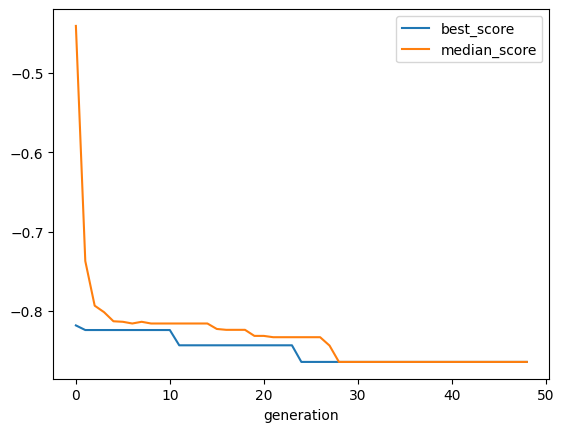

In [14]:
synth.plot_history()

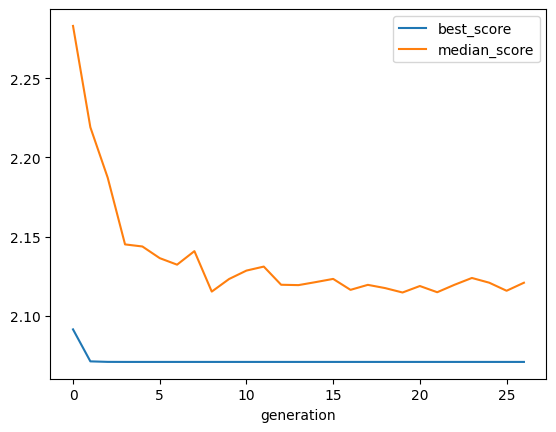

In [15]:
selector.plot_history()